In [ ]:
# !unzip /content/drive/MyDrive/Arrowhead\ Take\ Home\ Assignment/Summaries.zip -d /content/drive/MyDrive/Arrowhead\ Take\ Home\ Assignment/

In [ ]:
# !unzip /content/drive/MyDrive/Arrowhead\ Take\ Home\ Assignment/News\ Articles.zip -d /content/drive/MyDrive/Arrowhead\ Take\ Home\ Assignment/

In [1]:
# !nvtop

/bin/bash: nvtop: command not found


# Fine-tuning Large Language Models for Text Summarization of BBC News Articles

## Installing / Importing Libraries

Import (run only if not already installed in environment)

In [ ]:
!pip install transformers==4.28.0
!pip install rouge_score
!pip install datasets

Install

In [2]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm

import matplotlib.pyplot as plt
import torch
from statistics import mean, median
from datasets import load_metric
from transformers import pipeline
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, Seq2SeqTrainingArguments, Seq2SeqTrainer, DataCollatorForSeq2Seq
from sklearn.model_selection import train_test_split
from datasets import Dataset

In [3]:
# Chooses between GPU and CPU based on availability
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

## Organizing Data
- Traversing file directory, combining into a single CSV
- Run this section only if processed CSV is unavailable



In [4]:
# Change based on dataset location
DATA_DIR = '/content/drive/MyDrive/Arrowhead Assignment'

articles_dir = DATA_DIR + '/News Articles'
summaries_dir = DATA_DIR + '/Summaries'

In [5]:
# Initializing Pandas dataframe to store all news articles and summaries
dataset = pd.DataFrame(columns = ['category', 'article', 'summary'])

In [ ]:
# Traversing all directories to extract articles and summaries
for category in os.listdir(articles_dir):
    print(category)
    for file in tqdm(os.listdir(articles_dir + '/' + category)):
        # print (os.path.join(articles_dir, category, file))
        na = open(os.path.join(articles_dir, category, file), "r")
        sum = open(os.path.join(summaries_dir, category, file), "r")

        try:
            na, sum = na.read() , sum.read()
        except:
            print('category ' + category + ', file ' + file + ' has utf-8 encoding issue')
            continue
        row = pd.DataFrame

        new_row = pd.DataFrame({'category': category, 'article':na, 'summary':sum}, index=[0])
        dataset = pd.concat([new_row,dataset.loc[:]]).reset_index(drop=True)




tech


100%|██████████| 401/401 [00:01<00:00, 277.06it/s]


politics


100%|██████████| 417/417 [00:01<00:00, 277.96it/s]


sport


 47%|████▋     | 242/511 [00:00<00:00, 288.95it/s]

category sport, file 199.txt has utf-8 encoding issue


100%|██████████| 511/511 [00:01<00:00, 283.05it/s]


business


100%|██████████| 510/510 [00:01<00:00, 285.29it/s]


entertainment


100%|██████████| 386/386 [00:01<00:00, 291.15it/s]


In [ ]:
# checking the final pandas dataframe
dataset

In [ ]:
# saving as CSV for future use
dataset.to_csv('/content/drive/MyDrive/Arrowhead Assignment/dataset.csv')

## Analyzing News Articles and Summaries
- Plotting histograms and calculating averages for News Articles and Summaries length
- This would help decide the max size of embedding for input and output

In [6]:
model_name = 'facebook/bart-large-cnn'
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [7]:
dataset = pd.read_csv('/content/drive/MyDrive/Arrowhead Assignment/dataset.csv', index_col=0)

In [8]:
# Converting pandas df to huggingface dataset
dataset = Dataset.from_pandas(dataset)
# 25% for testing
dataset = dataset.train_test_split(test_size=0.25)

In [30]:
# dataset['train']['article']

In [9]:
articles_len_list = [len(tokenizer.encode(article)) for article in dataset['train']['article']]
summaries_len_list = [len(tokenizer.encode(summary)) for summary in dataset['train']['summary']]

Token indices sequence length is longer than the specified maximum sequence length for this model (1039 > 1024). Running this sequence through the model will result in indexing errors


In [10]:
min_a, max_a, av_a = min(articles_len_list), max(articles_len_list), mean(articles_len_list)
min_s, max_s, av_s = min(summaries_len_list), max(summaries_len_list), mean(summaries_len_list)

In [11]:
print('Minimum Article Length:', min_a, '\tMaximum Article Length:', max_a, '\tAverage Article Length:', av_a)
print('Minimum Summary Length:', min_s, '\tMaximum Summary Length:', max_s, '\tAverage Summary Length:', av_s)

Minimum Article Length: 110 	Maximum Article Length: 5337 	Average Article Length: 485.2086330935252
Minimum Summary Length: 48 	Maximum Summary Length: 2535 	Average Summary Length: 212.3705035971223


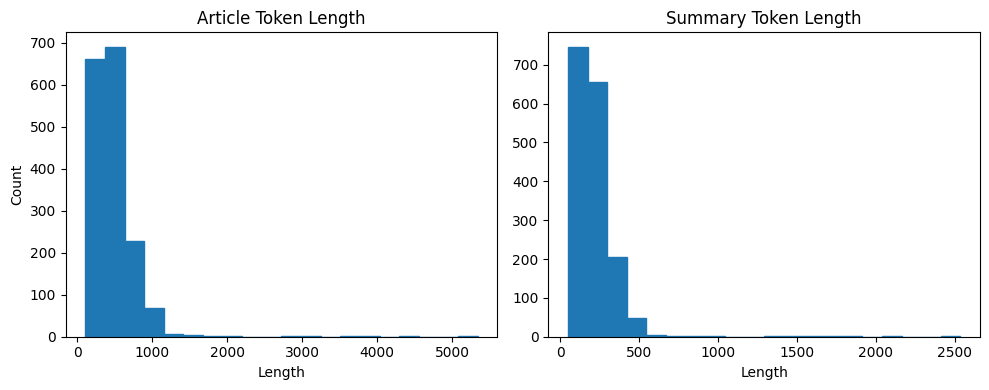

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey='col' )
axes[0].hist(articles_len_list, bins = 20, color = 'C0', edgecolor = 'C0' )
axes[0].set_title("Article Token Length")
axes[0].set_xlabel("Length")
axes[0].set_ylabel("Count")

axes[1].hist(summaries_len_list, bins = 20, color = 'C0', edgecolor = 'C0' )
axes[1].set_title("Summary Token Length")
axes[1].set_xlabel("Length")
plt.tight_layout()
plt.show()

In [13]:
MAX_LEN_ARTICLE = 1024
MAX_LEN_SUMMARY = 512

## Model 1: BART Large CNN by Facebook
- [Huggingface Model Card](https://huggingface.co/facebook/bart-large-cnn)
- Pretrained on English language, fine-tuned on the CNN Daily Mail dataset.
- Based on the paper [BART: Denoising Sequence-to-Sequence Pre-training for Natural Language Generation, Translation, and Comprehension by Lewis et al.](https://arxiv.org/abs/1910.13461).
- Both the pretraining and the sequence to sequence nature of the model make it suitable for this task.
- The available training data makes this an ***Extractive Text Summarization*** Task.

### Establishing basline results on Summarization
- Using the test split of the dataset (25%)
- No finetuning on BBC data to establish baseline
- Metrics: Rouge1, Rouge2, RougeL, RougeLSum

In [14]:
model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(DEVICE)

In [15]:
def generate_batches(data, batch_size):
    for i in range(0, len(data), batch_size):
        yield data[i : i + batch_size]

In [16]:
def eval(dataset, metric, model, tokenizer, batch_size=4, device=DEVICE):

    article_batches = list(generate_batches(dataset['article'], batch_size))
    summary_batches = list(generate_batches(dataset['summary'], batch_size))

    for article_batch, target_batch in tqdm(
        zip(article_batches, summary_batches), total=len(article_batches)):
        
        inputs = tokenizer(article_batch, max_length=MAX_LEN_ARTICLE,  truncation=True, padding="max_length", return_tensors="pt")
        
        summaries = model.generate(input_ids=inputs["input_ids"].to(device), attention_mask=inputs["attention_mask"].to(device), 
                         length_penalty=0.8, num_beams=8, max_length=MAX_LEN_SUMMARY)

        decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True, clean_up_tokenization_spaces=True) for s in summaries]      
        
        decoded_summaries = [d.replace("<n>", " ") for d in decoded_summaries]
        
        metric.add_batch(predictions=decoded_summaries, references=target_batch)
        
    return metric.compute()
 

In [17]:
# pipe = pipeline('summarization', model = model_name)
metric = load_metric('rouge')

<ipython-input-17-b508b5336cc2>:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric('rouge')


In [18]:
score = eval(dataset['test'], metric, model, tokenizer)

100%|██████████| 139/139 [04:29<00:00,  1.94s/it]


In [19]:
rouge_dict = dict((rn, score[rn].mid.fmeasure ) for rn in ["rouge1", "rouge2", "rougeL", "rougeLsum"] )
results = pd.DataFrame(rouge_dict, index = ['bart_baseline'])

In [20]:
results.to_csv('/content/drive/MyDrive/Arrowhead Assignment/results.csv')

### Finetuning on Train Set
- Features extraction similar to evaluation
- Train for 1 and 3 epochs, save weights and checkpoints
- Using saved weights for evaluation on test set
- Small batch size due to limited compute
- Improved results (ROUGE) over baseline by about minimum 100% (double)

In [21]:
def extract_features(batch):

    input_encodings = tokenizer(list(batch['article']) , max_length = int(MAX_LEN_ARTICLE), padding="max_length", return_tensors="pt", truncation = True)
    # with tokenizer.as_target_tokenizer():
    target_encodings = tokenizer(list(batch['summary']), max_length = int(MAX_LEN_SUMMARY), padding="max_length", return_tensors="pt", truncation = True)
        
    return {
        'input_ids' : input_encodings['input_ids'],
        'attention_mask': input_encodings['attention_mask'],
        'labels': target_encodings['input_ids']
    }

In [22]:
seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [23]:
dataset = dataset.map(extract_features, batched = True)

Map:   0%|          | 0/1668 [00:00<?, ? examples/s]

Map:   0%|          | 0/556 [00:00<?, ? examples/s]

In [24]:
# dataset

In [25]:
training_args = Seq2SeqTrainingArguments(
    #CHECK WEIGHTS FILE BEFORE RUNNING
    output_dir="/content/drive/MyDrive/Arrowhead Assignment/BART_1_ep",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    weight_decay=0.01,
    save_total_limit=3,
    #EPOCHS
    num_train_epochs=1,
    predict_with_generate=True,
    #BATCH SIZE
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    tokenizer=tokenizer,
)

trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a BartTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss
1,0.228800,0.066529


TrainOutput(global_step=834, training_loss=0.16547259095189668, metrics={'train_runtime': 455.7219, 'train_samples_per_second': 3.66, 'train_steps_per_second': 1.83, 'total_flos': 3614730476322816.0, 'train_loss': 0.16547259095189668, 'epoch': 1.0})

In [26]:
# CHECK PATH BEFORE RUNNING
torch.save(model.state_dict(), "/content/drive/MyDrive/Arrowhead Assignment/BART_1_ep.pth")

In [27]:
torch.cuda.empty_cache()

In [28]:
# CHECK PATH BEFORE RUNNING
model.load_state_dict(torch.load("/content/drive/MyDrive/Arrowhead Assignment/BART_1_ep.pth"))

<All keys matched successfully>

In [ ]:
score = eval(dataset['test'], metric, model, tokenizer)

 90%|████████▉ | 125/139 [21:51<02:26, 10.45s/it]

In [ ]:
results = pd.read_csv('/content/drive/MyDrive/Arrowhead Assignment/results.csv', index_col=0)

In [22]:
rouge_dict = dict((rn, score[rn].mid.fmeasure ) for rn in ["rouge1", "rouge2", "rougeL", "rougeLsum"] )
curr_results = pd.DataFrame(rouge_dict, index = ['bart_finetuned_1_ep'])

,rouge1,rouge2,rougeL,rougeLsum
bart_finetuned,0.69947,0.624174,0.527566,0.527599


In [ ]:
frames = [results, curr_results]
results = pd.concat(frames)

In [ ]:
results

### Inference
- This section has code to generate a summary given an article
- Input could be any instance of the test data (the model has been trained only on train data) or any other external data similar to the BBC dataset

In [ ]:
# Make sure model is loaded
model.load_state_dict()
generations_args = {'length_penalty': 0.8, 'num_beams': 8, 'max_length': MAX_LEN_SUMMARY}

In [ ]:
def generate_summary(article, generations_args):
    pipe = pipeline('summarization', model = model_name)
    print(pipe(article, **generations_args)[0]["summary_text"])

## Model 2: Pegasus by Google
- 

In [ ]:
dataset_2 = pd.read_csv('/content/drive/MyDrive/Arrowhead Assignment/dataset.csv', index_col=0)

In [ ]:
dataset_2 = Dataset.from_pandas(dataset_2)
dataset_2 = dataset_2.train_test_split(test_size=0.25)

In [ ]:
model_name_2 = 'google/pegasus-cnn_dailymail'
tokenizer_2 = AutoTokenizer.from_pretrained(model_name_2)
model_2 = AutoModelForSeq2SeqLM.from_pretrained(model_name_2).to(DEVICE)

### Establishing Baselind Results
- Similar to the earlier model
- To get a baseline of how the model performs with no finetunint

In [ ]:
model = AutoModelForSeq2SeqLM.from_pretrained(model_name_2).to(DEVICE)